In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-darkgrid')
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import joblib

C:\Users\ethan\AppData\Local\Temp\ipykernel_12888\3870603118.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ethan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ethan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ethan\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [23]:
# !wget https://github.com/priyanshkedia04/Tweets-Classification-among-Hate-Speech-Offensive-Neither/raw/master/data.csv

In [7]:
df = pd.read_csv('data.csv', index_col=0)

In [8]:
df.columns

Index(['count', 'hate_speech', 'offensive_language', 'neither', 'class',
       'tweet'],
      dtype='object')

In [9]:
# 0 - hate speech 1 - offensive language 2 - neither
df['class'].unique()

array([2, 1, 0], dtype=int64)

In [10]:
# only interested in label and tweet text
df = df[['class', 'tweet']].rename({'class': 'label'}, axis=1)

# change problem into binary classification by combining hate speech label and offensive language
df['label'] = df.label.map({2: 0, 0: 1, 1: 1})

# not negative speech - 0, negative speech - 1
df.head()

,label,tweet
0,0,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [11]:
# preprocess data
stop_words = set(stopwords.words("english"))
stop_words.add('rt')
stop_words.remove('not')
lemmatizer = WordNetLemmatizer()
giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|' '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
mention_regex = '@[\w\-]+'

def clean_text(text):
    text = re.sub('"', "", text)
    text = re.sub(mention_regex, ' ',text) #removing all user names
    text = re.sub(giant_url_regex, ' ', text)  #removing the urls
    text = text.lower()
    text = re.sub("hm+", "", text) #removing variants of hmmm
    text = re.sub("[^a-z]+", " ", text) #removing all numbers, special chars like @,#,? etc
    text = text.split()
    text = [word for word in text if not word in stop_words]
    text = [lemmatizer.lemmatize(token) for token in text]
    text = [lemmatizer.lemmatize(token, "v") for token in text]
    text = " ".join(text)
    return text

df['processed_tweets'] = df.tweet.apply(lambda x: clean_text(x)) 

Text(0, 0.5, 'Frequency')

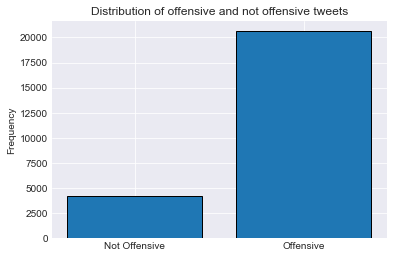

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)

mapping = {0: 'Not Offensive', 1: 'Offensive'}
values, counts = np.unique(df.label, return_counts=True)


ax.bar([mapping[v] for v in values], counts, edgecolor='black')

ax.set_xticks(np.arange(2))
ax.set_title('Distribution of offensive and not offensive tweets')
ax.set_ylabel('Frequency')

In [13]:
# prepare for training
X = df['processed_tweets'].to_numpy()
y = df['label'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

corpus = X_train.copy()
vectorizer = TfidfVectorizer()

X_train = vectorizer.fit_transform(corpus).toarray()
X_test = vectorizer.transform(X_test).toarray()

In [14]:
joblib.dump(vectorizer, 'vectorizer.pkl')

['vectorizer.pkl']

In [15]:
def z_norm(X, mu, sigma):
    return (X - mu) / sigma

mu, sigma = X_train.mean(axis=0).reshape(1, -1), X_train.std(axis=0).reshape(1, -1)

In [16]:
with open('stats.npy', 'wb') as f:
    np.save(f, mu)
    np.save(f, sigma)

In [17]:
X_train = z_norm(X_train, mu, sigma)
X_test = z_norm(X_test, mu, sigma)

In [21]:
clf = RandomForestClassifier(n_estimators=100, criterion='gini')

In [22]:
clf.fit(X_train, y_train)

RandomForestClassifier()

In [24]:
y_preds_train = clf.predict(X_train)

In [25]:
print(f'train accuracy: {accuracy_score(y_train, y_preds_train)}')
print(f'train precision: {precision_score(y_train, y_preds_train)}')
print(f'train recall: {recall_score(y_train, y_preds_train)}')
print(f'train f1 score: {f1_score(y_train, y_preds_train)}')

train accuracy: 0.9993442953697166
train precision: 0.9998180825905039
train recall: 0.9993938659231422
train f1 score: 0.9996059292491436


In [26]:
y_preds_test = clf.predict(X_test)

In [27]:
print(f'test accuracy: {accuracy_score(y_test, y_preds_test)}')
print(f'test precision: {precision_score(y_test, y_preds_test)}')
print(f'test recall: {recall_score(y_test, y_preds_test)}')
print(f'test f1 score: {f1_score(y_test, y_preds_test)}')

test accuracy: 0.9489610651603793
test precision: 0.9658078497471707
test recall: 0.9730713245997089
test f1 score: 0.9694259818731118


<AxesSubplot: title={'center': 'Confusion Matrix'}>

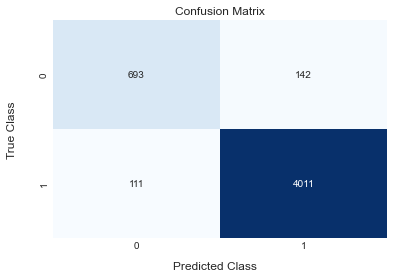

In [28]:
# evaluate model performance
cf_mat = confusion_matrix(y_test, y_preds_test)
fig3 = plt.figure()
ax3 = fig3.add_subplot(111)
ax3.set_title('Confusion Matrix')
fig3.supylabel('True Class')
fig3.supxlabel('Predicted Class')
sns.heatmap(cf_mat, cmap='Blues', cbar=False, annot=True, fmt='g', ax=ax3)

In [29]:
# save model
joblib.dump(clf, 'random_forest_clf.pkl') 

['random_forest_clf.pkl']

: 